# Proyecto IMT-2200, Grupo 31

## 1. Contexto y motivación


La Superintendencia de Casinos de Juego (SCJ) hace públicos mensualmente los ingresos brutos que obtienen los casinos autorizados en Chile. En este estudio buscamos estudiar estos datasets, analizando brechas entre diferentes establecimientos y juegos, y obtener un enfoque limpio para el análisis de desempeño, ganancia del jugador promedio, y recaudación fiscal.


- **Problema**: explicar la concentración de ingresos brutos de dinero entre los distintos casinos y cuantificar las brechas entre montos recaudados, la potencial ganancia del jugador promedio, y los aportes fiscales generados.

- **Objetivos específicos**:
  - Estimar la magnitud y variabilidad de los ingresos brutos por casino y mes.
  - Identificar qué información adicional se requiere para calcular el retorno efectivo al jugador promedio y el monto total apostado.
  - Evaluar la oferta de juegos reportada por la SCJ y detectar vacíos de datos que impiden caracterizar similitudes entre establecimientos.

- **Motivación**:
  - La industria del juego en Chile es un sector económico relevante, y entender su dinámica puede ayudar a mejorar la regulación y supervisión.
  - Analizar los ingresos y la distribución de ganancias puede proporcionar información valiosa para los responsables de políticas públicas y para los propios casinos.
  - Identificar brechas y vacíos en los datos puede guiar futuras mejoras en la recolección y reporte de información por parte de la SCJ.
  - Contribuir al conocimiento público sobre la industria del juego en Chile, promoviendo la transparencia y el análisis crítico de su funcionamiento.

### Configuración del entorno, del notebook

Antes de iniciar cargamos las librerías a utilizar, fijamos los path, y ajustamos opciones de formato para que las salidas numéricas sean legibles.

In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv

# Ahora, definimos el path del proyecto, y los directorios a utilizar:
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
DATA_DIR = Path(os.path.join(PROJECT_ROOT, "data"))
FIGURES_DIR = Path(os.path.join(PROJECT_ROOT, "figures"))
FIGURES_DIR.mkdir(parents=True, exist_ok=True)  # Esto crea el directorio si no existe.

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"FIGURES_DIR: {FIGURES_DIR}")

PROJECT_ROOT: c:\Users\carlo\Desktop\PUC\IMT2200 - Intro a Ciencia de Datos\Proyecto-IMT-2200-2-Grupo-5
DATA_DIR: c:\Users\carlo\Desktop\PUC\IMT2200 - Intro a Ciencia de Datos\Proyecto-IMT-2200-2-Grupo-5\data
FIGURES_DIR: c:\Users\carlo\Desktop\PUC\IMT2200 - Intro a Ciencia de Datos\Proyecto-IMT-2200-2-Grupo-5\figures


### Limpieza de archivos semi-estructurados
Los CSV oficiales incluyen encabezados repetidos, separadores inconsistentes y varios bloques por fichero.

#### Flujo de limpieza paso a paso
1. **`split_blocks`** separa cada archivo en mini-tablas utilizando las líneas en blanco o separadores auxiliares como cortes.

2. **`find_header_idx`** recorre cada bloque y ubica la fila que contiene el encabezado real de la tabla.

3. **`clean_column_names`** estandariza los nombres de columnas obtenidos, reemplazando celdas vacías por identificadores neutrales.

4. **`coerce_numeric`** transforma cadenas con puntos y comas en valores numeric cuando los datos lo permiten.

5. **`load_tables`** Organiza, mediante las funciones anteriores el flujo: abre el fichero, segmenta en bloques, ajusta encabezados y normaliza columnas antes de devolver cada tabla lista para hacer uso de ellas.

6. Finalmente, el bucle sobre `DATA_DIR.glob("*.csv")` invoca `load_tables` en cada fichero, arma el diccionario `DATASETS` y lo deja disponible para que seleccionemos la tabla principal en los pasos siguientes cualquier segmento del dataset que necesitemos.

La siguiente celda está generada con un LLM, para poder perparar la creación de la multitabla que agrupará los datasets (csv).

In [3]:
def split_blocks(lines, separator: str = ";"):
    """Reúne las líneas en bloques continuos para aislar cada tabla cruda que trae el CSV."""
    blocks = []
    current_block = []

    for line in lines:
        stripped_line = line.strip()
        if not stripped_line:
            if current_block:
                blocks.append(current_block)
                current_block = []
            continue

        parts = [part.strip() for part in line.split(separator)]
        if all(part == "" for part in parts):
            if current_block:
                blocks.append(current_block)
                current_block = []
            continue

        current_block.append(line)

    if current_block:
        blocks.append(current_block)
    return blocks


def find_header_idx(block, separator: str) -> int:
    """Recorre el bloque para ubicar la primera fila que parece encabezado real."""
    for idx, line in enumerate(block):
        parts = [part.strip() for part in line.split(separator)]
        non_empty = sum(part != "" for part in parts)
        if non_empty >= 3:
            return idx
    return 0


def clean_column_names(columns):
    """Normaliza los nombres de columnas: elimina espacios y crea etiquetas cuando faltan."""
    renamed = []
    seen: dict[str, int] = {}
    for idx, col in enumerate(columns):
        base_name = str(col).strip()
        if not base_name or base_name.lower().startswith("unnamed"):
            base_name = f"col_{idx:02d}"
        count = seen.get(base_name, 0)
        if count > 0:
            name = f"{base_name}_{count}"
        else:
            name = base_name
        seen[base_name] = count + 1
        renamed.append(name)
    return renamed


def coerce_numeric(series: pd.Series) -> pd.Series:
    """Convierte una columna de texto a number cuando la mayoría de sus valores lo permiten"""
    if series.dtype != object:
        return series
    candidate = series.astype("string")
    candidate = candidate.str.replace(".", "", regex=False)
    candidate = candidate.str.replace(",", ".", regex=False).str.strip()
    candidate = candidate.replace({"": pd.NA, "<NA>": pd.NA})
    non_null_count = candidate.notna().sum()
    if non_null_count == 0:
        return series
    numeric_mask = candidate.dropna().str.fullmatch(r"-?\d+(?:\.\d+)?")
    numeric_ratio = numeric_mask.sum() / non_null_count
    if numeric_ratio >= 0.6:
        coerced = pd.to_numeric(candidate, errors="coerce")
        return coerced
    return series

### Creación de una multi-tabla
Cada archivo puede contener varias tablas, así que el siguiente bloque descompone esas tablas y arma un repositorio que se accede por su nombre, para mayor facilidad en la manipulación.

In [4]:
def load_tables(path): # Función generada con AI
    """Lee un fichero y devuelve cada bloque tabular como un nuevo DF limpio"""
    with path.open("r", encoding="latin-1") as fh: # Una codificación común en archivos CSV en español es latin-1
        lines = fh.readlines()

    blocks = split_blocks(lines, separator=";")
    tables = []


    for block in blocks:
        header_idx = find_header_idx(block, ";")
        data_lines = block[header_idx:]
        if not data_lines:
            continue

        # Parseamos el bloque directamente con csv.reader para evitar buffers temporales
        parsed_rows = [[cell.strip() for cell in row] for row in csv.reader(data_lines, delimiter=";")]
        if not parsed_rows:
            continue

        header_raw, *data_rows = parsed_rows
        if not data_rows:
            continue

        max_len = max(len(header_raw), *(len(row) for row in data_rows))
        header_extended = header_raw + ["" for _ in range(max_len - len(header_raw))]
        normalized_rows = [
            row + ["" for _ in range(max_len - len(row))]
            for row in data_rows
        ]

        table = pd.DataFrame(normalized_rows, columns=header_extended)
        table.columns = clean_column_names(table.columns)
        table = table.replace(r"^\s*$", pd.NA, regex=True)
        table = table.dropna(axis=0, how="all").dropna(axis=1, how="all")
        if table.empty:
            continue

        object_columns = table.select_dtypes(include="object").columns
        for col in object_columns:
            table[col] = table[col].apply(lambda x: x.strip() if isinstance(x, str) else x)
            table[col] = table[col].replace({"": pd.NA, "<NA>": pd.NA})

        for col in table.columns:
            table[col] = coerce_numeric(table[col])

        tables.append(table)

    return tables


def build_dataset_index(data_dir):
    """Recorre todos los CSV del directorio y arma el diccionario de DATASETS"""
    dataset_index: dict[str, pd.DataFrame] = {}
    for csv_path in sorted(data_dir.glob("*.csv")):
        tables_in_file = load_tables(csv_path)
        for idx, table in enumerate(tables_in_file, start=1):
            key = f"{csv_path.stem}__{idx:02d}"
            dataset_index[key] = table
    return dataset_index


DATASETS = build_dataset_index(DATA_DIR)
if not DATASETS:
    raise FileNotFoundError("No se encontraron archivos CSV en el directorio data/.")


print(f"Tablas detectadas: {len(DATASETS)}")
for key in list(DATASETS.keys()):
    rows, cols = DATASETS[key].shape
    print(f"  - {key}: {rows} filas × {cols} columnas")

Tablas detectadas: 15
  - Impuestos__01: 20 filas × 15 columnas
  - Impuestos__02: 20 filas × 15 columnas
  - IngresosBrutosJuego__01: 20 filas × 15 columnas
  - OfertaJuegos__01: 20 filas × 7 columnas
  - ParqueMaquinas__01: 21 filas × 18 columnas
  - PosicionesJuego__01: 64 filas × 8 columnas
  - ResumenIndustria__01: 7 filas × 14 columnas
  - ResumenIndustria__02: 8 filas × 14 columnas
  - ResumenIndustria__03: 8 filas × 15 columnas
  - ResumenIndustria__04: 6 filas × 13 columnas
  - RetornoMaquinas__01: 20 filas × 15 columnas
  - RetornoMaquinas__02: 20 filas × 14 columnas
  - Visitas__01: 18 filas × 14 columnas
  - Visitas__02: 20 filas × 15 columnas
  - Visitas__03: 20 filas × 15 columnas


### Selección y normalización de la tabla principal
Elegimos el bloque de ingresos brutos como base del análisis y removemos filas/columnas de totales que duplican información.

In [524]:
TARGET_DATASET = "IngresosBrutosJuego"
selected_key = next((key for key in DATASETS if key.startswith(TARGET_DATASET)), next(iter(DATASETS)))

# Eliminamos filas resumen (Total), referencias a tipo de cambio y columnas sin datos para quedarnos con observaciones útiles
df_raw = DATASETS[selected_key].copy()
id_column = df_raw.columns[0]
name_series = df_raw[id_column].astype(str)
mask_totals = name_series.str.contains("total", case=False, na=False)
mask_exchange = name_series.str.contains("d[oó]lar|promedio", case=False, na=False)
mask_invalid = mask_totals | mask_exchange
if mask_invalid.any():
    df = df_raw.loc[~mask_invalid].reset_index(drop=True)
    print(
        "Filas removidas automáticamente:",
        df_raw.loc[mask_invalid, id_column].tolist()
    )
else:
    df = df_raw.copy()

empty_columns = [col for col in df.columns if df[col].isna().all()]
if empty_columns:
    df = df.drop(columns=empty_columns)
    print(f"Columnas eliminadas por falta total de datos: {empty_columns}")

print(f"Tabla principal seleccionada: {selected_key}")
print(f"Forma final: {df.shape[0]} filas × {df.shape[1]} columnas")

Filas removidas automáticamente: ['Total $', 'Total US$', 'Dólar promedio observado']
Columnas eliminadas por falta total de datos: ['Diciembre']
Tabla principal seleccionada: IngresosBrutosJuego__01
Forma final: 17 filas × 14 columnas


### Exploración inmediata
Verificamos un vistazo rápido a las primeras filas y generamos un resumen de tipos/nulos para asegurarnos de que la estructura final sea consistente.

In [525]:
# Vista general y metadatos de las columnas
df_head = df.head()
df_info = pd.DataFrame({
    "columna": df.columns,
    "tipo": df.dtypes.astype(str),
    "nulos": df.isnull().sum(),
    "% nulos": (df.isnull().mean() * 100).round(2)
})

display(df_head)
display(df_info)

,Casinos de Juego,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Total ($),Total (US$)
0,Casino Sol Calama,1035767085.00,935429689.00,1048468403.00,1092595098.00,1179989308.00,1132027981.00,1181272641.00,1213447594.00,1081164672.00,1108914349.00,1151796080.00,12160872900,24959479
1,Enjoy Antofagasta,2202162439.00,2106257899.00,2430453521.00,2329430339.00,2450249085.00,2381432756.00,2433416389.00,2428481737.00,2392195352.00,2287005198.00,2195242286.00,25636327001,52617424
2,Antay Casino & Hotel,903056986.00,804171002.00,1011270680.00,973826114.00,1046271302.00,972892205.00,1008637781.00,1052849448.00,979857794.00,942829598.00,913799360.00,10609462270,21774674
3,Casino de Juegos del Pacífico,609320866.00,595904409.00,434609706.00,433556311.00,411312413.00,395549903.00,479085670.00,415957862.00,512917703.00,437162325.00,463463580.00,5188840748,10652826
4,Casino Rinconada,2576732673.00,2438045749.00,2998928440.00,2945006808.00,3269058088.00,2896777107.00,3450401055.00,3432419611.00,3097659119.00,3609253045.00,3577927532.00,34292209227,70456429


,columna,tipo,nulos,% nulos
Casinos de Juego,Casinos de Juego,object,0,0.00
Enero,Enero,Float64,2,11.76
Febrero,Febrero,Float64,2,11.76
Marzo,Marzo,Float64,2,11.76
Abril,Abril,Float64,1,5.88
Mayo,Mayo,Float64,0,0.00
Junio,Junio,Float64,0,0.00
Julio,Julio,Float64,0,0.00
Agosto,Agosto,Float64,0,0.00
Septiembre,Septiembre,Float64,0,0.00


## 3. Datos


- **Fuentes**:  Boletín estadístico de la Superintendencia de Casinos de Juego (a noviembre de 2012): https://datos.gob.cl/dataset/3985/resource/febd82fb-2b87-4cef-aebf-46ede878a769

- **Cobertura**: 18 casinos en operación regular. Cada registro resume los ingresos brutos del casino para un mes concreto; las columnas de totales agregan el acumulado anual.

- **Licencia / restricciones**: información de libre acceso provista por un servicio público chileno


- **Procedimiento de limpieza**: lectura en bruto línea a línea, segmentación de tablas (`split_blocks`), detección del encabezado real (`find_header_idx`), normalización de nombres (`clean_column_names`), conversión numérica (`coerce_numeric`) y descarte de filas/columnas de totales redundantes.

- **Calidad observada**: los meses de enero, febrero y marzo presentan 11,11 % de valores faltantes; abril y los totales solo 5,56 %. El resto de las columnas no tiene nulos, por lo que se podrán imputar ajustes puntuales sin afectar seriamente el análisis.

## 4. Análisis exploratorio de datos

In [546]:
# Estadísticas descriptivas generales
summary_global = df.describe(include="all").transpose() # Transponemos para mejor legibilidad

print(summary_global.describe())
display(summary_global)
print(summary_global.info())

summary_global.to_csv(os.path.join(FIGURES_DIR, "resumen_estadistico.csv"), index=True)

        count  unique                top  freq          mean           std  \
count      14       1                  1     1         13.00         13.00   
unique      3       1                  1     1         13.00         13.00   
top        17      17  Casino Sol Calama     1 1493522387.27 1607373673.70   
freq       10       1                  1     1          1.00          1.00   

               min          25%          50%           75%           max  
count        13.00        13.00        13.00         13.00         13.00  
unique       13.00        13.00        13.00         13.00         13.00  
top    30350563.00 607498257.50 903056986.00 1897334271.00 6529839805.00  
freq          1.00         1.00         1.00          1.00          1.00  


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Casinos de Juego,17,17,Casino Sol Calama,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Enero,15.00,<NA>,<NA>,<NA>,1493522387.27,1607373673.70,30350563.00,607498257.50,903056986.00,1897334271.00,6529839805.00
Febrero,15.00,<NA>,<NA>,<NA>,1372854207.67,1347517724.56,40207985.00,590090734.00,901678356.00,1852536646.50,5414744090.00
Marzo,15.00,<NA>,<NA>,<NA>,1513155812.73,1597348266.25,14791300.00,566594998.00,909455522.00,2066888162.50,6262877018.00
Abril,16.00,<NA>,<NA>,<NA>,1447618955.12,1568871555.01,26829416.00,485657070.25,916232015.50,1862641433.00,6245009749.00
Mayo,17.00,<NA>,<NA>,<NA>,1435784888.82,1590115975.61,13207904.00,411312413.00,837112044.00,1751390983.00,6290592866.00
Junio,17.00,<NA>,<NA>,<NA>,1405446501.06,1602558557.12,24859788.00,395549903.00,878744420.00,1779137883.00,6531399640.00
Julio,17.00,<NA>,<NA>,<NA>,1494492059.12,1688952103.21,38606304.00,425221475.00,945732082.00,1763865417.00,6794344184.00
Agosto,17.00,<NA>,<NA>,<NA>,1516311751.65,1786858313.22,34329748.00,415957862.00,902984145.00,1793432553.00,7217690792.00
Septiembre,17.00,<NA>,<NA>,<NA>,1447561364.82,1628876961.87,28121361.00,512917703.00,880833807.00,1738300827.00,6623598842.00


<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, Casinos de Juego to Total (US$)
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   count   14 non-null     object
 1   unique  1 non-null      object
 2   top     1 non-null      object
 3   freq    1 non-null      object
 4   mean    13 non-null     object
 5   std     13 non-null     object
 6   min     13 non-null     object
 7   25%     13 non-null     object
 8   50%     13 non-null     object
 9   75%     13 non-null     object
 10  max     13 non-null     object
dtypes: object(11)
memory usage: 1.9+ KB
None


Es importante que analicemos la distribución de valores faltantes para poder priorizar qué columnas requieren de una estimación posterior, qué campos deberían eliminarse por falta de evidencia y qué hipótesis se verán limitadas por la ausencia de datos. 

Si tenemos claro ese ese "mapa" de nulos, más fácil será decidir si conviene rellenar con el promedio simple, interpolación de meses o, de una vez, excluir variables para los análisis posteriores porque tienen muchos nulos.

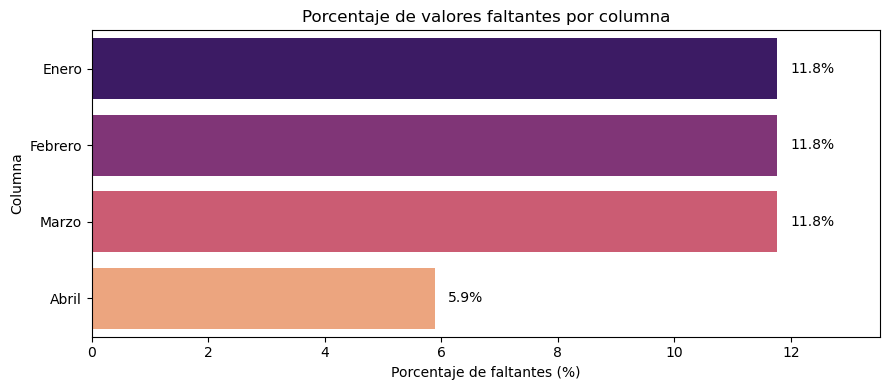

,faltantes,%,no_faltantes
Enero,2,11.76,15
Febrero,2,11.76,15
Marzo,2,11.76,15
Abril,1,5.88,16
Casinos de Juego,0,0.00,17
Mayo,0,0.00,17
Junio,0,0.00,17
Julio,0,0.00,17
Agosto,0,0.00,17
Septiembre,0,0.00,17


In [ ]:
# Aquí analizamos los datos faltantes
missing_ratio = df.isna().mean().sort_values(ascending=False)
missing_ratio = missing_ratio[missing_ratio > 0]

if missing_ratio.empty:
    print("No se detectaron valores faltantes en estas columnas!")
else:
    missing_ratio_pct = missing_ratio.mul(100)
    max_ratio = missing_ratio_pct.max()
    plt.figure(figsize=(9, 4))
    ax = sns.barplot(x=missing_ratio_pct.values, y=missing_ratio_pct.index, palette="magma")
    plt.title("Porcentaje de valores faltantes por columna")
    plt.xlabel("Porcentaje de faltantes (%)")
    plt.ylabel("Columna")
    padding = 5 if max_ratio < 5 else max_ratio * 0.15
    ax.set_xlim(0, max_ratio + padding)
    offset = max(max_ratio * 0.02, 0.2)
    
    for patch, value in zip(ax.patches, missing_ratio_pct.values): # Bucle generado con AI
        x = patch.get_width()
        y = patch.get_y() + patch.get_height() / 2
        ax.text(x + offset, y, f"{value:.1f}%", va="center", ha="left")
        
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "missing_ratio.png"), dpi=150)
    plt.show()

missing_summary = (
    pd.DataFrame({
        "faltantes": df.isna().sum(),
        "%": (df.isna().mean() * 100).round(2),
        "no_faltantes": df.notna().sum(),
    })
    .sort_values("%", ascending=False)
)
missing_summary # Lo mostramos

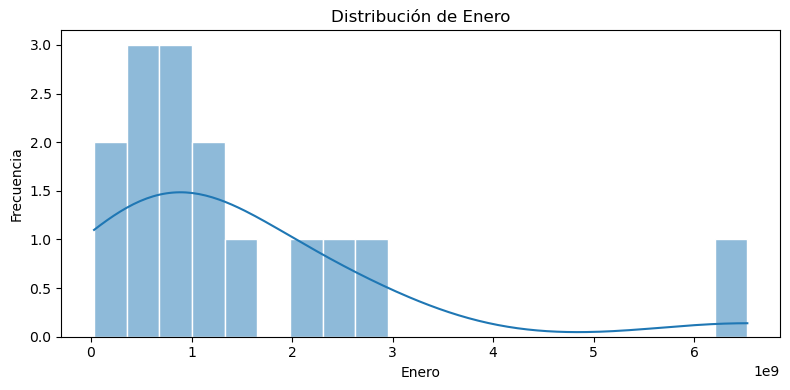

 Enero: valores van de 30,350,563 a 6,529,839,805. La mitad central cae entre 607,498,258 y 1,897,334,271.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


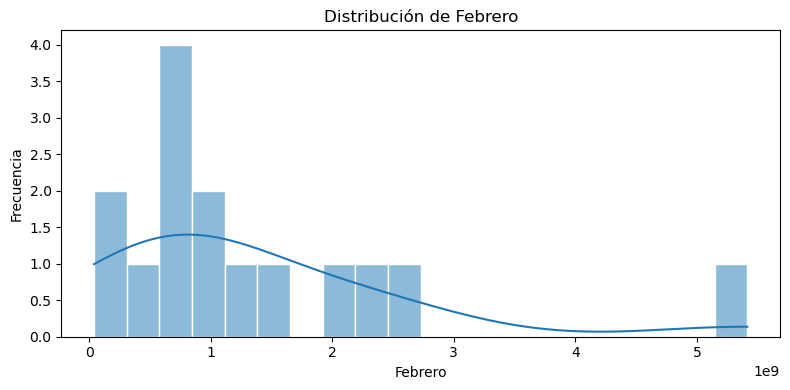

 Febrero: valores van de 40,207,985 a 5,414,744,090. La mitad central cae entre 590,090,734 y 1,852,536,646.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


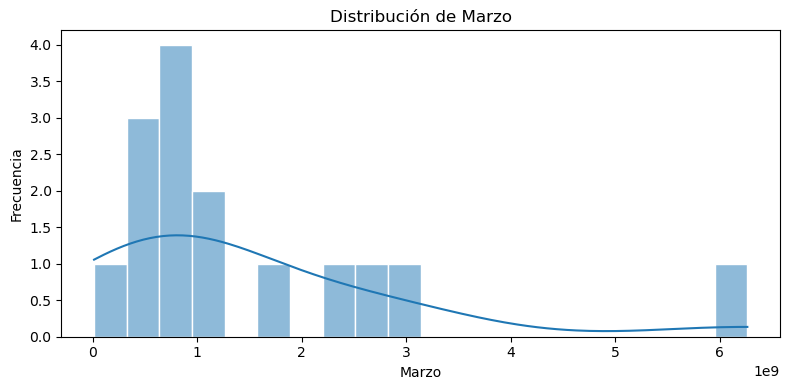

 Marzo: valores van de 14,791,300 a 6,262,877,018. La mitad central cae entre 566,594,998 y 2,066,888,162.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


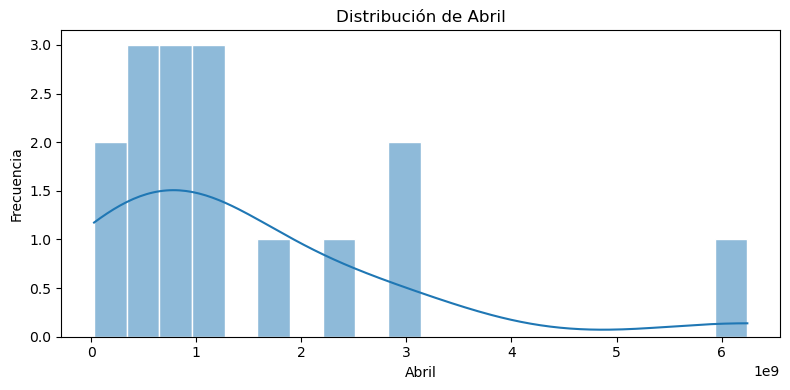

 Abril: valores van de 26,829,416 a 6,245,009,749. La mitad central cae entre 485,657,070 y 1,862,641,433.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


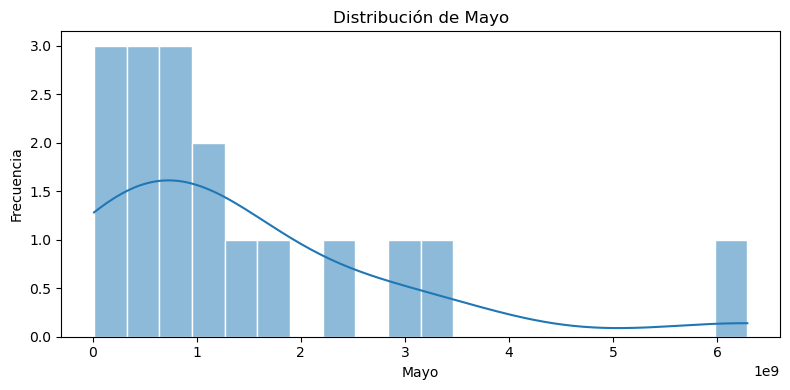

 Mayo: valores van de 13,207,904 a 6,290,592,866. La mitad central cae entre 411,312,413 y 1,751,390,983.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


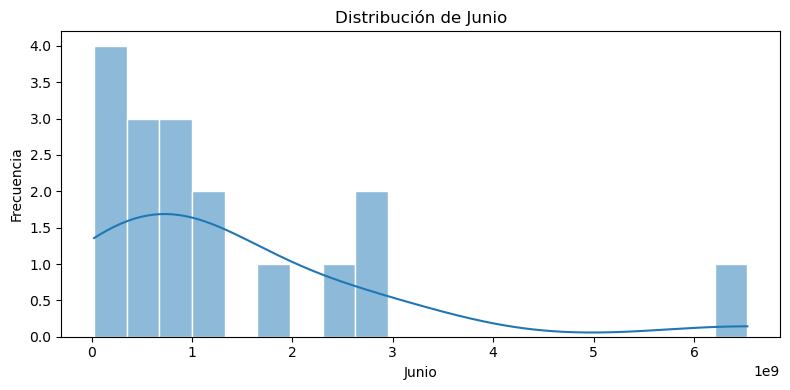

 Junio: valores van de 24,859,788 a 6,531,399,640. La mitad central cae entre 395,549,903 y 1,779,137,883.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


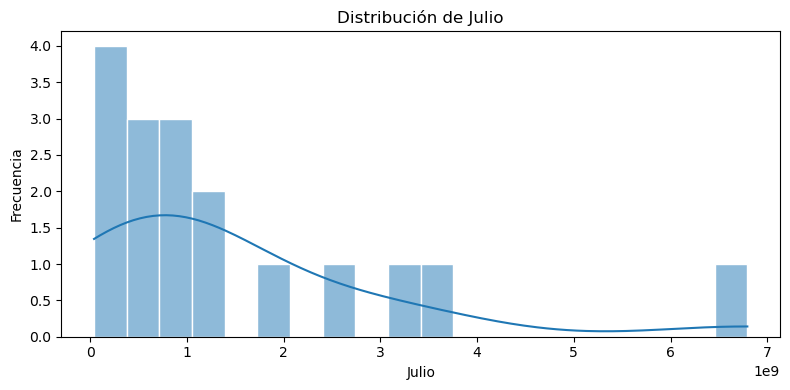

 Julio: valores van de 38,606,304 a 6,794,344,184. La mitad central cae entre 425,221,475 y 1,763,865,417.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


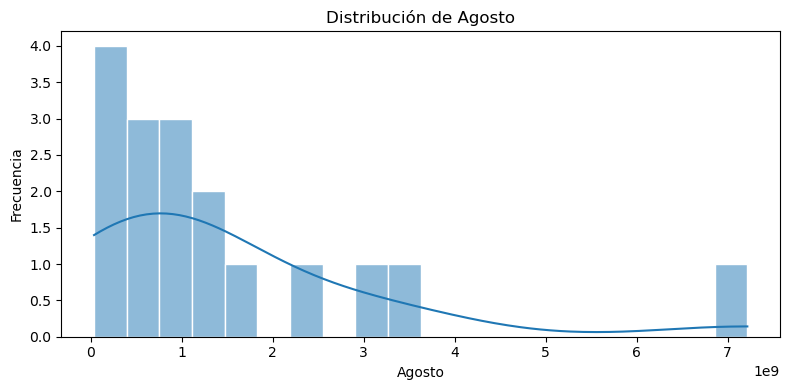

 Agosto: valores van de 34,329,748 a 7,217,690,792. La mitad central cae entre 415,957,862 y 1,793,432,553.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


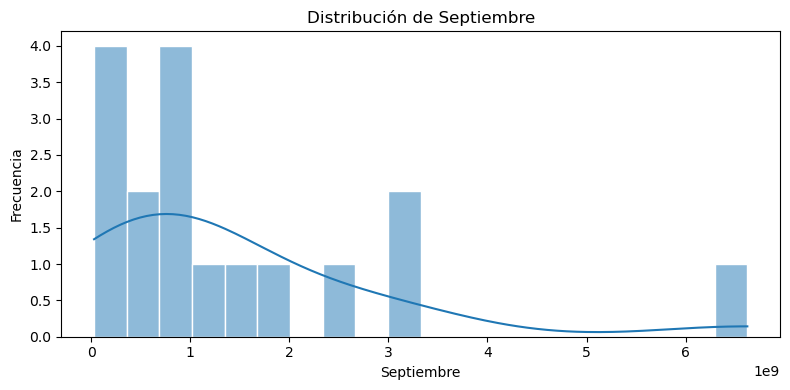

 Septiembre: valores van de 28,121,361 a 6,623,598,842. La mitad central cae entre 512,917,703 y 1,738,300,827.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


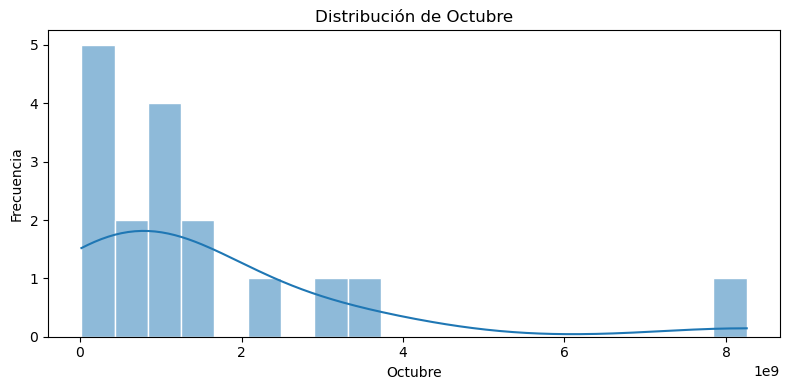

 Octubre: valores van de 16,993,145 a 8,257,326,721. La mitad central cae entre 427,217,966 y 1,663,635,252.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


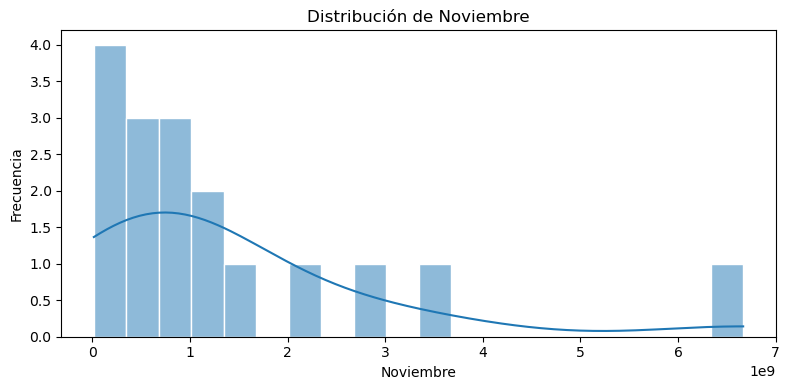

 Noviembre: valores van de 15,322,992 a 6,668,233,379. La mitad central cae entre 451,686,016 y 1,600,583,726.
  Cola derecha pronunciada: algunos casinos concentran montos muy altos.


In [ ]:
# Distribuciones de variables numéricas relevantes
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Priorizamos columnas mensuales y evitamos graficar totales agregados que distorsionan la lectura
# las tres siguientes líneas fueron generadas con AI:
filtered_numeric = [col for col in numeric_columns if "total" not in col.lower()]
numeric_candidates = filtered_numeric if filtered_numeric else numeric_columns
numeric_candidates = [col for col in numeric_candidates if df[col].notna().sum() >= 3]

if not numeric_candidates:
    print("No hay variables numéricas con datos suficientes para graficar sin los totales.")
else:
    for column in numeric_candidates:
        plt.figure(figsize=(8, 4))
        series = df[column].dropna()
        sns.histplot(series, kde=True, bins=20, edgecolor="white")
        plt.title(f"Distribución de {column}")
        plt.xlabel(column)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        output_path = os.path.join(FIGURES_DIR, f"hist_{column}.png")
        plt.savefig(output_path, dpi=150)
        plt.show()

        # Explicación rápida de la forma observada
        q25, q75 = series.quantile([0.25, 0.75])
        min_val, max_val = series.min(), series.max()
        
        print(
            f" {column}: valores van de {min_val:,.0f} a {max_val:,.0f}. "
            f"La mitad central cae entre {q25:,.0f} y {q75:,.0f}."
        )
        
        if series.skew() > 0:
            print("  Cola derecha pronunciada: algunos casinos concentran montos muy altos.")
        elif series.skew() < 0:
            print("  Cola izquierda pronunciada: pocos valores muy bajos respecto al resto.")
        else:
            print("  Distribución aproximadamente simétrica.")

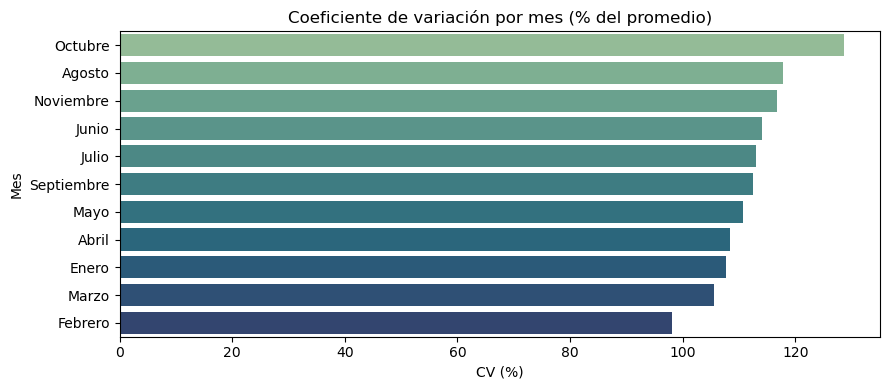

,Casinos de Juego,CV (%)
0,Termas de Chillán,37.59
1,Dreams Coyhaique,28.65
2,Casino de Juegos del Pacífico,15.40
3,Dreams Punta Arenas,13.26
4,Enjoy Chiloé,12.70
5,Casino Rinconada,12.56
6,Monticello Grand Casino,10.59
7,Casino Gran Los Ángeles,9.55
8,Marina del Sol,7.93
9,Casino de Colchagua,7.89


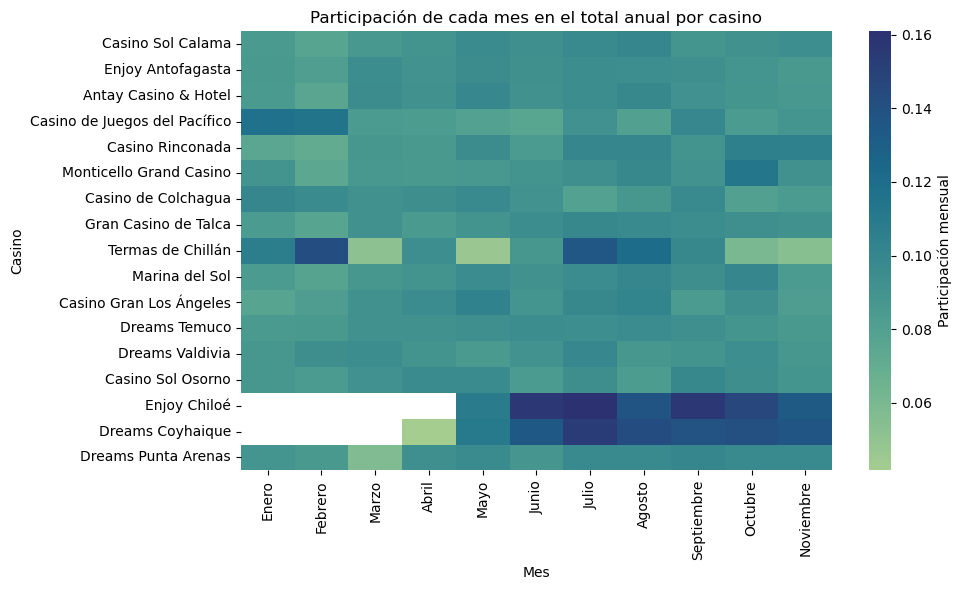

In [529]:
# Variabilidad mensual y participación relativa
MONTH_ORDER = [
    "Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre",
 ]

monthly_columns = [col for col in MONTH_ORDER if col in df.columns]

if not monthly_columns:
    raise ValueError("No se identificaron columnas mensuales en la tabla seleccionada!")

df_months = df[monthly_columns].apply(pd.to_numeric, errors="coerce") # hacemos conversión a number y coercemos errores
df_months = df_months.astype(float)

if "Casinos de Juego" in df.columns:
    df_months.index = df["Casinos de Juego"] # Asignamos nombres de casinos como índice del Series

monthly_cv = (df_months.std() / df_months.mean()).mul(100).sort_values(ascending=False) # Línea generada con AI
plt.figure(figsize=(9, 4))
sns.barplot(x=monthly_cv.values, y=monthly_cv.index, palette="crest")
plt.title("Coeficiente de variación por mes (% del promedio)")
plt.xlabel("CV (%)")
plt.ylabel("Mes")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "cv_mensual.png"), dpi=150)
plt.show()

casino_cv = (df_months.std(axis=1) / df_months.mean(axis=1)).mul(100).sort_values(ascending=False) # Línea generada con AI
cv_table = (
    casino_cv.rename("CV (%)").reset_index().rename(columns={"index": "Casinos de Juego"}) # Línea generada con AI
 )
display(cv_table)

row_totals = df_months.sum(axis=1).replace(0, np.nan)
monthly_shares = df_months.div(row_totals, axis=0).astype(float)
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_shares, cmap="crest", cbar_kws={"label": "Participación mensual"})
plt.title("Participación de cada mes en el total anual por casino")
plt.xlabel("Mes")
plt.ylabel("Casino")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "participacion_mensual_casinos.png"), dpi=150)
plt.show()

### Coeficiente de variación (CV) por cada casino

El gráfico anterior muestra el CV por cada mes, esto es, se muestra cómo se dispersan los ingresos cuando comparamos a todos los casinos entre sí dentro de un mismo mes; por eso algunos valores superan el 100 % cuando la brecha es muy grande. 

En la siguiente celda calcularemos el CV por cada casino, midiendo cuánto fluctúa a lo largo del año.
Estos CV suelen ser menores porque reflejan la variación de cada casino en particular mensualmente, no la dispersión entre casinos, es un análisis importante a considerar, ya que nos entrega información más particular de cada establecimiento.

,Casinos de Juego,CV (%)
0,Termas de Chillán,37.59
1,Dreams Coyhaique,28.65
2,Casino de Juegos del Pacífico,15.40
3,Dreams Punta Arenas,13.26
4,Enjoy Chiloé,12.70
5,Casino Rinconada,12.56
6,Monticello Grand Casino,10.59
7,Casino Gran Los Ángeles,9.55
8,Marina del Sol,7.93
9,Casino de Colchagua,7.89


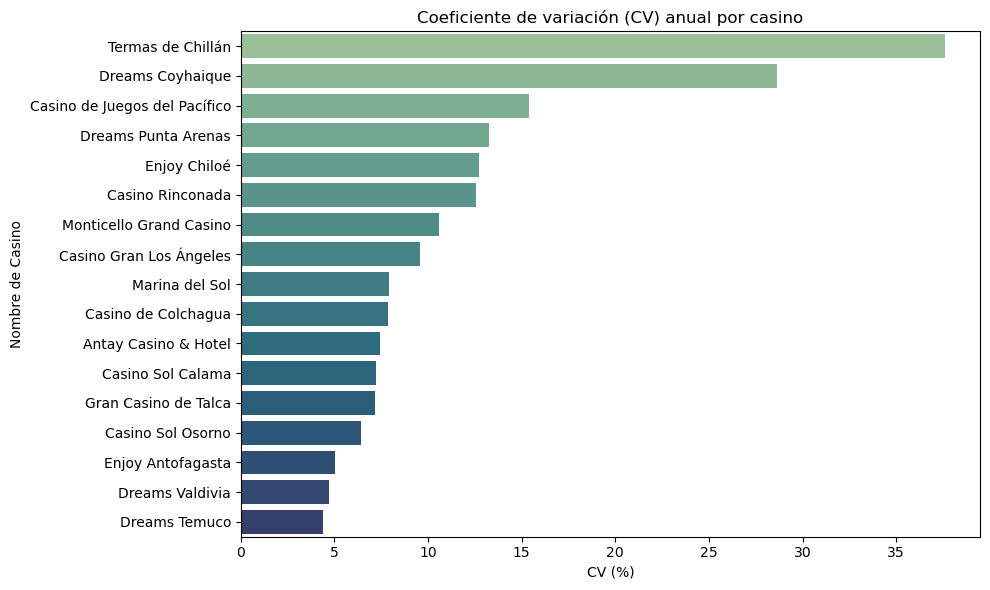

In [530]:
casino_cv = (df_months.std(axis=1) / df_months.mean(axis=1)).mul(100).sort_values(ascending=False)
cv_table = (
    casino_cv.rename("CV (%)").reset_index().rename(columns={"index": "Casinos de Juego"})
)
display(cv_table)

plt.figure(figsize=(10, 6))
sns.barplot(y=casino_cv.index, x=casino_cv.values, palette="crest")
plt.title("Coeficiente de variación (CV) anual por casino")
plt.xlabel("CV (%)")
plt.ylabel("Nombre de Casino")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "cv_por_casino.png"), dpi=150)
plt.show()

En la siguiente celda, se ha utilizado un LLM para poder obtener correctamente los valores representativos, ya que algunos datos en las columnas categóricas no tienen valores válidos.

También, para convertir a una unidad de miles de millones de pesos Chilenos, se ha utilizado un LLM, en la variable scale_factor.

Para agregar los números a la derecha de cada barra, se ha generado un bucle con un LLM.

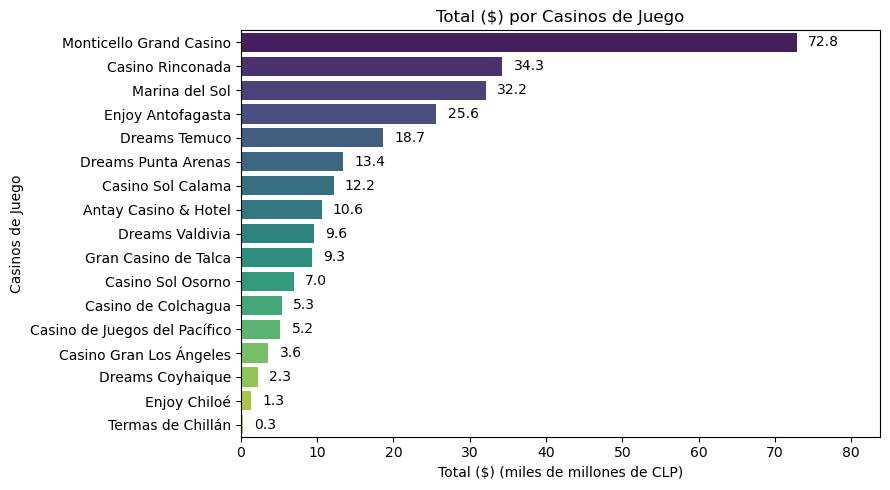

In [531]:
# Obtenemos las columnas categóricas (que son los ejes para agrupar) y las numéricas (valores)
categorical_columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
value_columns = df.select_dtypes(include=[np.number]).columns.tolist()

if not categorical_columns: # Necesitamos categóricas para clasificar!
    print("No hay variables categóricas con variación suficiente para graficar.")
else:
    metric_candidates = [col for col in value_columns if "total" in col.lower()]
    default_metric = metric_candidates[0] if metric_candidates else (value_columns[0] if value_columns else None)

    for column in categorical_columns:
        valid_values = df[column].dropna() # Excluimos nulos para el conteo
        distinct = valid_values.nunique()

        if distinct <= 1:
            print(f"La columna no presenta variación útil para el análisis.")
            continue

        if distinct == valid_values.shape[0] and default_metric:
            ranking = (
                df[[column, default_metric]]
                .dropna(subset=[default_metric])
                .sort_values(default_metric, ascending=False)
            )
            plot_df = ranking.copy()
            scale_factor = 1e9 if plot_df[default_metric].max() > 5e8 else 1e6
            scale_label = "miles de millones" if scale_factor == 1e9 else "millones"
            plot_df[default_metric] = plot_df[default_metric] / scale_factor

            fig, ax = plt.subplots(figsize=(9, 5))
            sns.barplot(data=plot_df, y=column, x=default_metric, palette="viridis", ax=ax)
            unidad = "CLP"
            ax.set_title(f"{default_metric} por {column}")
            ax.set_xlabel(f"{default_metric} ({scale_label} de {unidad})")
            ax.set_ylabel(column)
            max_width = max((patch.get_width() for patch in ax.patches), default=0)
            offset = max(max_width * 0.02, 0.1)
            if max_width > 0:
                ax.set_xlim(0, max_width * 1.15)
            for patch in ax.patches: # Etiquetamos cada barra con su valor escalado
                width = patch.get_width()
                y = patch.get_y() + patch.get_height() / 2
                ax.text(width + offset, y, f"{width:,.1f}", va="center", ha="left")
            plt.tight_layout()
            output_path = os.path.join(FIGURES_DIR, f"metric_{column}.png")
            plt.savefig(output_path, dpi=150)
            plt.show()
        else:
            order = valid_values.value_counts().index
            fig, ax = plt.subplots(figsize=(9, 5))
            sns.countplot(data=df, y=column, order=order, palette="viridis", ax=ax)
            ax.set_title(f"Frecuencias de {column}")
            max_width = max((patch.get_width() for patch in ax.patches), default=0)
            offset = max(max_width * 0.02, 0.1)
            if max_width > 0:
                ax.set_xlim(0, max_width * 1.15)
            for patch in ax.patches: # Etiquetamos cada barra con su frecuencia
                width = patch.get_width()
                y = patch.get_y() + patch.get_height() / 2
                ax.text(width + offset, y, f"{int(width)}", va="center", ha="left")
            plt.tight_layout()
            output_path = os.path.join(FIGURES_DIR, f"count_{column}.png")
            plt.savefig(output_path, dpi=150)
            plt.show()

### Extra: Analisis de procedencia de máquinas de azar
Con los datos disponibles en el CSV `ParqueMaquinas`, podemos analizar la procedencia de las máquinas de azar en los casinos chilenos. Este análisis nos permitirá entender mejor la diversidad y origen de los equipos utilizados en la industria del juego en Chile.

In [25]:
# Extra: Análisis de procedencia de máquinas de azar, usando un enfoque manual debido a la complejidad del CSV para una lectura automática.
file_path = DATA_DIR / 'ParqueMaquinas.csv'
    # 1. Definir manualmente los encabezados (Fabricantes) y Países
    # Lista de Fabricantes (Fila 10, columnas 1 a -2)
fabricantes_list = [
    'ANSWORTH', 'ARISTOCRAT', 'ARUZE', 'SPIELO', 'BALLY', 'Elektroncek', 
    'GOLDCLUB', 'ID Interactive', 'IGT', 'KONAMI', 'MERKUR', 
    'Multimedia Games', 'NOVOMATIC', 'UNDESA', 'WMS'
]

# Lista de Países (Fila 11, columnas 1 a -2)
paises_list = [
    'Australia', 'Australia-USA', 'USA-Australia', 'Alemania-USA', 'USA', 
    'Slovenia', 'Slovenia', 'USA', 'USA', 'USA-Japón', 'Alemania', 'USA', 
    'Austria', 'España', 'USA'
]

# Nombres de todas las columnas (incluyendo la primera y las dos últimas)
all_headers = [
    'Casinos', 'ANSWORTH', 'ARISTOCRAT', 'ARUZE', 'SPIELO', 'BALLY', 
    'Elektroncek', 'GOLDCLUB', 'ID Interactive', 'IGT', 'KONAMI', 'MERKUR', 
    'Multimedia Games', 'NOVOMATIC', 'UNDESA', 'WMS', 
    'Total por Casino', 'Porcentaje'
]

# 2. Cargar el archivo, omitiendo TODAS las filas de encabezado problemáticas
# skiprows=11 omite las 8 de basura + 1 Título + 1 Fabricantes + 1 Países
df_data = pd.read_csv(
    file_path, 
    delimiter=';', 
    skiprows=11, 
    header=None, 
    encoding='latin-1'
)

# 3. Asignar los nombres de columna manualmente
# Asegurar que las longitudes coincidan
num_cols_data = df_data.shape[1]
if len(all_headers) > num_cols_data:
    all_headers = all_headers[:num_cols_data]
elif len(all_headers) < num_cols_data:
    df_data = df_data.iloc[:, :len(all_headers)]
    
df_data.columns = all_headers

# 4. Crear el DataFrame de resumen
df_by_manufacturer = pd.DataFrame({
    "Fabricante": fabricantes_list,
    "País de Origen": paises_list
})

# 5. Limpiar Footers
try:
    stop_index = df_data[df_data['Casinos'] == 'Total por Fabricante'].index[0]
    df_data_cleaned = df_data.loc[:stop_index-1]
except Exception as e:
    # Usar iloc[:-3] si falla la búsqueda (excluye Total, %, Al 30-11)
    df_data_cleaned = df_data.iloc[:-3]

# 6. Sumar
total_machines = []
for col in fabricantes_list:
    if col not in df_data_cleaned.columns:
        total_machines.append(0)
        continue
        
    # Limpieza de datos:
    # 1. Reemplazar '.' (separador de miles) por nada.
    # 2. Reemplazar NaN (celdas vacías) por '0'.
    cleaned_series = df_data_cleaned[col].str.replace('.', '', regex=False).fillna('0')
    # 3. Convertir a numérico (errores a NaN, luego a 0)
    numeric_series = pd.to_numeric(cleaned_series, errors='coerce').fillna(0)
    # 4. Sumar
    total_machines.append(numeric_series.sum())

# 7. Finalizar
df_by_manufacturer["Cantidad de Máquinas"] = total_machines
df_by_manufacturer["Cantidad de Máquinas"] = df_by_manufacturer["Cantidad de Máquinas"].astype(int)

total_general = df_by_manufacturer["Cantidad de Máquinas"].sum()
if total_general > 0:
    df_by_manufacturer['% Participación'] = (df_by_manufacturer['Cantidad de Máquinas'] / total_general * 100).round(1).astype(str) + '%'
else:
    df_by_manufacturer['% Participación'] = '0.0%'

df_by_manufacturer = df_by_manufacturer.sort_values(by="Cantidad de Máquinas", ascending=False)
df_by_manufacturer

,Fabricante,País de Origen,Cantidad de Máquinas,% Participación
4,BALLY,USA,1649,18.5%
3,SPIELO,Alemania-USA,1640,18.4%
14,WMS,USA,1621,18.1%
8,IGT,USA,1501,16.8%
1,ARISTOCRAT,Australia-USA,984,11.0%
12,NOVOMATIC,Austria,884,9.9%
9,KONAMI,USA-Japón,488,5.5%
0,ANSWORTH,Australia,60,0.7%
7,ID Interactive,USA,21,0.2%
10,MERKUR,Alemania,20,0.2%


Como podemos apreciar es una tabla bastante completa, que nos entrega información relevante sobre el fabricante y país de origen de las máquinas de azar en los casinos chilenos. Mas tendremos que tener en cuenta que hay varios valores nulos en las columnas de fabricante y país de origen, lo que podría limitar el análisis en cierta medida.

## 2. Preguntas objetivo

Ponemos las preguntas objetivo en esta celda MD, posterior al análisis exploratorio de los datos, ya que tiene más sentido responderlas con la obtención de un muestreo previo de los datos:

1. **¿Cuál es el retorno real promedio a jugadores en máquinas de azar?** Parcialmente: el CSV `RetornoMaquinas` permite comparar el payout observado por tipo de juego y casino, identificando cuáles retornan más dinero al jugador. Aun así, falta una traza completa de premios pagados para, hilando las ganancias de los jugadores, estimar el retorno efectivo del jugador promedio.

2. **¿Cuál es el monto total apostado en juegos de azar?** Tampoco se puede responder con este dataset, ya que no se registran montos apostados, únicamente ingresos brutos.

3. **¿Cuáles son los ingresos brutos de juegos de azar?** Monticello Grand Casino y el Casino Rinconada superan los 30 mil millones de CLP en 2023, mientras varios casinos regionales se mantienen por debajo de los 6 mil millones.

4. **¿Cuál es la oferta de juegos distribuida por casino?** Sí: los CSV `PosicionesJuegos` y `RetornoMaquinas` enumeran posiciones de juego y características de cada máquina, lo que permite describir la oferta disponible en cada operador.

5. **¿Cuál es el resumen de la industria en el periodo de estudio?** Sí: el coeficiente de variación mensual supera 120 % en octubre y agosto, los ingresos están concentrados en dos operadores y los nulos se limitan a enero-marzo (11,1 %) y a los totales (5,6 %).

6. **¿Qué similitudes presentan algunos casinos? (Extra)** Con los datos disponibles solo comparamos variabilidad mensual y participación relativa; faltan variables adicionales para un análisis más profundo.

7. **¿Cuál es el origen de las máquinas de azar? (Extra)** Podemos responder parcialmente esta pregunta en base al CSV `ParqueMaquinas`, que detalla el fabricante y procedencia, durante el analisis exploratorio de datos, pudimos darnos cuenta que la mayoría de las máquinas provienen de Estados Unidos, habiendo varios fabricantes como BALLY, SPIELO y WMS que dominan el mercado chileno de máquinas de azar, con mas de un 18% de participación cada uno.

### 4.1 Hallazgos preliminares


- **Ingresos brutos**: Monticello Grand Casino y Casino Rinconada aportan más del 40% del total anual de ingresos, ellos tienen una alta concentración del mercado.

- **Variabilidad mensual**: Octubre y agosto exhiben coeficientes de variación superiores al 120 %, mientras febrero es el mes más estable en este sentido, el contraste sugiere que realicemos un análisis de tipo estacinario para ver patrones en ciertos meses donde hay más flujo de dinero en los casinos.

- **No hay demasiada calidad y cobertura de datos de los casinos**: Los datasets carecen de "payout", montos apostados, flujo de personas e información sobre ellos, oferta de juegos en específico, variables de similitud y origen de las máquinas, por lo que necesariemente tendremos algunas de las preguntas objetivo sin responder, o con una respuesta parcial, no completamente satisfactoria.

## 5. Desafíos metodológicos y próximos pasos a seguir en la siguiente entrega


- **Datos faltantes**: Algunos meses, como enero, febrero y marzo tienen valores ausentes, próximamente decidiremos si debemos excluirlos o promediarlos de alguna manera para los análisis.

- **Variables faltantes**: Para responder las preguntas 1, 2 y 4 necesitamos series de pagos, montos apostados y oferta de juegos, como otros datos necesarios para responder mínimamente la pregunta y, aunque la pregunta 1 puede ser respondida parcialmente, hay una escasez de material para realizar un análisis profundo y, quizás "quirúrjico", necesitaríamos muchos más datos específicos.

- **Escala y comparación**: Hay una diferencia de tamaño en los casinos, saber cuántos visitantes tiene cada uno de ellos, ayudaría a realizar algún tipo de comparación con una métrica que haga justicia a la comparación, con indicadores normalizados que permitan hacer una justa equiparación.

- **Próximos pasos**: Como podemos ver, hay varios desafíos metodológicos que debemos abordar en la siguiente entrega. Primero, debemos decidir cómo manejar los datos faltantes, ya sea mediante exclusión o imputación. Además, necesitamos buscar fuentes adicionales de datos para llenar las lagunas en las variables faltantes, especialmente para responder a las preguntas clave del análisis. También es crucial desarrollar métricas normalizadas que permitan comparaciones justas entre casinos de diferentes tamaños. Finalmente, planeamos realizar análisis estadísticos más profundos y visualizaciones para identificar patrones y tendencias en los datos disponibles.

## 6. Referencias
Se ha utilizado como LLM GPT-5-Codex y Gemini Flash, en su mayoría está su uso citado en las celdas de MarkDown, como también en comentarios de las funciones o líneas de código generadas con esa herramienta, pero en su mayoría se ha utilizado para solucionar errores en los tipos de datos.

Repositorio del proyecto en GitHub. https://github.com/ReToxiE/Proyecto-IMT-2200-2-Grupo-5

Boletín estadístico de la Superintendencia de Casinos de Juego (a noviembre de 2012).
https://datos.gob.cl/dataset/3985/resource/febd82fb-2b87-4cef-aebf-46ede878a769

Wikipedia - Casino. https://es.wikipedia.org/wiki/Casino

Artículo 1 - Los ingresos de los casinos de Chile crecen un 2 % en mayo. https://www.gamingintelligence.com/es/finanzas/balances/68865-chile-mayo/

Artículo 2 - Crece el mercado del juego en Chile. https://www.theclinic.cl/2024/10/16/poker-con-dinero-real-en-su-version-online/

Estudio - “Radiografía de la apuesta en Chile al 2023, ”Caracterización del jugador online”. https://accj.cl/wp-content/uploads/2023/06/ppt-estudio-radiografia-apuesta-online-2023.pdf

Superintendencia de Casinos de Juego - *Resultados de casinos*. https://www.scj.cl

### Autores

- GitHub - Matías V. https://github.com/aesmatias

- GitHub - Carlos R. https://github.com/Ex-0m

- GitHub - Benjamín U. https://github.com/ReToxiE

- GitHub - Brian M. https://github.com/brianmunozaylwin
